In [1]:
def run_segmentation_model(model_path, train_path, val_path, test_path):
  model = YOLO(model_path)
  results_train = model(train_path, save=True)
  results_val = model(val_path, save=True)
  results_test = model(test_path, save=True)
  return model, results_train, results_val, results_test

In [2]:
def split_data(folder_path):
  images_folder_path = os.path.join(folder_path) # change to where all pictures are stored
  filenames = [f for f in os.listdir(images_folder_path)]
  train_imgs, test_imgs = train_test_split(filenames, test_size=0.2, random_state=42)
  train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.2, random_state=42)
  os.makedirs(os.path.join(folder_path, 'train'), exist_ok=True)
  os.makedirs(os.path.join(folder_path, 'val'), exist_ok=True)
  os.makedirs(os.path.join(folder_path, 'test'), exist_ok=True)
  for img in train_imgs:
    shutil.move(os.path.join(images_folder_path, img), os.path.join(folder_path, 'train', img))
  for img in val_imgs:
    shutil.move(os.path.join(images_folder_path, img), os.path.join(folder_path, 'val', img))
  for img in test_imgs:
    shutil.move(os.path.join(images_folder_path, img), os.path.join(folder_path, 'test', img))

In [3]:
def created_model_input(results):
    tongue_class = 0
    blue_circle_class_id = 1

    top_tongue_bounds = {}
    normalized = {}
    normalized_padded = {}

    for result in results:
        image_name = result.path.split('/')[-1]
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes (x_min, y_min, x_max, y_max)
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class IDs

        # Filter tongue boxes
        tongue_boxes = [
            (box, score) for box, score, cls in zip(boxes, scores, classes) if cls == tongue_class
        ]
        # Sort by confidence and take the top 3
        tongue_boxes = sorted(tongue_boxes, key=lambda x: x[1], reverse=True)[:3]
        top_tongue_bounds[image_name] = tongue_boxes

        normalized_images = []
        image_path = result.path
        image = cv2.imread(image_path)

        blue_circle_box = next(
            (box for box, cls in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.cls.cpu().numpy())
            if cls == blue_circle_class_id),
            None
        )
        if blue_circle_box is None:
            print(image_name)
            continue

        # Compute the center pigment value
        x_min, y_min, x_max, y_max = map(int, blue_circle_box)
        center_x = (x_min + x_max) // 2
        center_y = (y_min + y_max) // 2
        center_pixel_value = image[center_y, center_x]  # BGR pixel value

        # Normalize tongue bounding boxes
        for (box, score) in top_tongue_bounds.get(image_name, []):
            x_min, y_min, x_max, y_max = map(int, box)
            nail_region = image[y_min:y_max, x_min:x_max]

            # Normalize pixel values by center pigment
            normalized_tongue = nail_region / center_pixel_value
            normalized_images.append(normalized_tongue)

        normalized[image_name] = normalized_images

    for key, images in normalized.items():
        if not images:  # If no images are associated with the key
            print(f"Warning: No images for key '{key}'.")
            continue

        while len(images) < 3:
            images.append(images[-1])  # Duplicate the last image until there are 3
        normalized_padded[key] = images[:3]

    return normalized_padded

In [4]:
def obtain_hb_data(hb_file, sheet_name):
  hb_data = pd.read_excel(hb_file, sheet_name = sheet_name)
  return hb_data

In [5]:
def label_with_hb(tongue_hb_data, normalized):
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))
  ])

  inputs = []
  targets = []

  for _, row in tongue_hb_data.iterrows():
    image_name = row['Tongue_Images']
    hb_value = torch.tensor(row['Hb_Value'], dtype=torch.float32)

    if image_name in normalized:
        images = normalized[image_name]
        combined_image = torch.cat([transform(img) for img in images], dim=2)
        inputs.append(combined_image)
        targets.append(hb_value)

  inputs = torch.stack(inputs)
  targets = torch.tensor(targets)

  return inputs, targets

In [6]:
def convert_to_tensors(inputs, targets, batch_size, shuffle):
  data = torch.utils.data.TensorDataset(inputs, targets)
  loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=shuffle)
  return data, loader

In [7]:
def regression_model_setup():
  class EfficientNet9ChannelsModel(nn.Module):
    def __init__(self, pretrained=True):
        super(EfficientNet9ChannelsModel, self).__init__()
        # Load the pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

        # Modify the first convolution layer to accept 3 input channels
        self.efficientnet.features[0][0] = nn.Conv2d(
            3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
        )

        # Add dropout to features for regularization
        self.dropout = nn.Dropout(p=0.3)  # Dropout with 30% probability

        # Modify the classifier to output 1 value (for regression)
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.5),  # Dropout with 50% probability before final layer
            nn.Linear(self.efficientnet.classifier[1].in_features, 1)
        )

    def forward(self, x):
        x = self.efficientnet.features(x)
        x = self.dropout(x)  # Apply dropout to the features
        x = self.efficientnet.avgpool(x)  # Use the pre-defined avgpool
        x = torch.flatten(x, 1)
        x = self.efficientnet.classifier(x)
        return x

  # class MobileNet9ChannelsModel(nn.Module):
  #   def __init__(self, pretrained=True):
  #       super(MobileNet9ChannelsModel, self).__init__()
  #       # Load the pre-trained MobileNetV2 model
  #       self.mobilenet = models.mobilenet_v2(pretrained=pretrained)

  #       self.mobilenet.features[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

  #       self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, 1)

  #   def forward(self, x):
  #       return self.mobilenet(x)

  model = EfficientNet9ChannelsModel(pretrained=True) #MobileNet9ChannelsModel(pretrained=True)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

  return model, criterion, optimizer

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                inputs = inputs.float()
                targets = targets.float()

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        print(f"Validation Loss: {val_loss / len(val_loader):.4f}")

In [9]:
def test_model(model, test_loader, criterion, tolerance=0.5, display_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    all_targets = []
    all_predictions = []
    sample_count = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            outputs = model(inputs)
            predictions = outputs.view(-1) #squeeze()

            loss = criterion(predictions, targets)
            test_loss += loss.item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            if sample_count < display_samples:
                for i in range(len(targets)):
                    print(f"Sample {sample_count + 1}:")
                    print(f"  Predicted: {predictions[i].item():.4f}")
                    print(f"  Actual:    {targets[i].item():.4f}")
                    sample_count += 1
                    if sample_count >= display_samples:
                        break

    plt.scatter(all_targets, all_predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.title("Regression: Actual vs Predicted Hb Values")
    plt.xlabel("Actual Hb Values")
    plt.ylabel("Predicted Hb Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    r2 = r2_score(all_targets, all_predictions)

    # Display results
    print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    return {"mae": mae, "mse": mse, "r2": r2}

In [10]:
!pip install ultralytics

from google.colab import drive
from ultralytics import YOLO
import pandas as pd
import torch
from torchvision import transforms
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import zipfile


drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/AI_ML_Project/images'
model_path = '/content/drive/MyDrive/AI_ML_Project/best.pt'


#split_data(folder_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



image 1/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709617694248.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 20.4ms
image 2/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709617844626.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 19.3ms
image 3/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709619874657.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 13.4ms
image 4/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709620272757.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 13.3ms
image 5/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709621754449.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 13.3ms
image 6/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709622707347.jpg: 1024x1024 1 tongue, 1 colorcard, 1 blue, 17.8ms
image 7/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709623407879.jpg: 1024x1024 1 tongue, 3 colorcards, 1 blue, 16.4ms
image 8/107 /content/drive/MyDrive/AI_ML_Project/images/train/1709624561582.jpg: 1024x1024 1 to

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 62.5MB/s]


Epoch [1/40], Loss: 135.6493
Validation Loss: 116.6409
Epoch [2/40], Loss: 109.0194
Validation Loss: 86.5562
Epoch [3/40], Loss: 79.4984
Validation Loss: 45.1484
Epoch [4/40], Loss: 51.7417
Validation Loss: 7.1963
Epoch [5/40], Loss: 33.5202
Validation Loss: 8.7954
Epoch [6/40], Loss: 17.8091
Validation Loss: 14.1674
Epoch [7/40], Loss: 11.0725
Validation Loss: 8.1000
Epoch [8/40], Loss: 6.8168
Validation Loss: 21.9576
Epoch [9/40], Loss: 6.1363
Validation Loss: 38.4186
Epoch [10/40], Loss: 6.3770
Validation Loss: 65.4413
Epoch [11/40], Loss: 4.1626
Validation Loss: 37.8717
Epoch [12/40], Loss: 7.4734
Validation Loss: 29.1160
Epoch [13/40], Loss: 5.0287
Validation Loss: 22.2489
Epoch [14/40], Loss: 7.7054
Validation Loss: 7.6094
Epoch [15/40], Loss: 10.6315
Validation Loss: 6.9720
Epoch [16/40], Loss: 5.2419
Validation Loss: 11.9679
Epoch [17/40], Loss: 4.7710
Validation Loss: 13.4711
Epoch [18/40], Loss: 2.5480
Validation Loss: 7.2776
Epoch [19/40], Loss: 2.5542
Validation Loss: 6.933

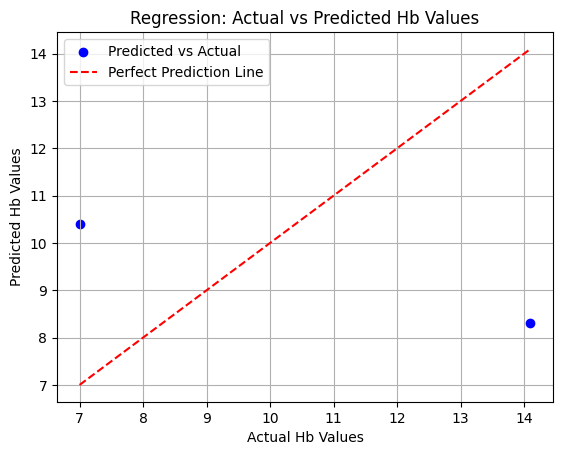


Test Loss: 22.5238
Mean Absolute Error (MAE): 4.5926
Mean Squared Error (MSE): 22.5238
R-squared (R²): -0.7872


In [11]:
model, results_train, results_val, results_test = run_segmentation_model('/content/drive/MyDrive/AI_ML_Project/best.pt',
                                                            '/content/drive/MyDrive/AI_ML_Project/images/train',
                                                            '/content/drive/MyDrive/AI_ML_Project/images/val',
                                                            '/content/drive/MyDrive/AI_ML_Project/images/test')
segmented_train_input = created_model_input(results_train)
segmented_val_input = created_model_input(results_val)
segmented_test_input = created_model_input(results_test)

hb_data = obtain_hb_data("/content/drive/MyDrive/AI_ML_Project/Anemia_dataset_train.xlsx", 'Tongue_Data')

train_inputs, train_targets = label_with_hb(hb_data, segmented_train_input)
val_inputs, val_targets = label_with_hb(hb_data, segmented_val_input)
test_inputs, test_targets = label_with_hb(hb_data, segmented_test_input)

train_data, train_loader = convert_to_tensors(train_inputs, train_targets, batch_size=10, shuffle=True)
val_data, val_loader = convert_to_tensors(val_inputs, val_targets, batch_size=10, shuffle=True)
test_data, test_loader = convert_to_tensors(test_inputs, test_targets, batch_size=10, shuffle=True)

regression_model, criterion, optimizer = regression_model_setup()
train_model(regression_model, train_loader, val_loader, criterion, optimizer, num_epochs=40)
metrics = test_model(regression_model, test_loader, criterion, display_samples=10)